# **Curso**: Deep Learning

[<img align="right" width="400" height="100" src="https://assets.website-files.com/5f909dbbf6ef7c3b428e2522/60f4592942eda3c0ffb35bfd_Logo_QLAB.svg">](https://qlab.pucp.edu.pe/)


[Pedro Achanccaray](mailto:p.diaz@tu-bs.de), y [Smith Arauco](mailto:saraucoc@uni.pe).

[Pontificia Universidad Católica del Perú](https://www.pucp.edu.pe/)  
[Laboratorio de Inteligencia Artificial y Métodos Computacionales en Ciencias Sociales](https://qlab.pucp.edu.pe/formacion-continua)

# **Lab 1.2: Multi Layer Perceptron (MLP) para clasificación de imágenes**

En esta sesión vamos a ver los siguientes temas:
- Multi Layer Perceptron (MLP)
- Clasificación de Imágenes

Vamos a usar el conjunto de datos [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) para clasificación de imágenes.

Este conjunto de datos tiene las siguientes clases:

<center>

| Clase | Descripción |
|:-----:|:-----------:|
|   0   | T-shirt/top |
|   1   |   Trouser   |
|   2   |  Pullover   |
|   3   |   Dress     |
|   4   |   Coat      |
|   5   |    Sandal   |
|   6   |    Shirt    |
|   7   |    Sneaker  |
|   8   |     Bag     |
|   9   |  Ankle boot |

</center>

Algunas muestras del conjunto de datos:

<center>

<img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" height=400/>

</center>

## **Montar Google Drive a Google Colab**

**Ejecutar las siguiente lineas de código solo si deseas guardar el módelo entrenado.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/DL_QLAB/Deep_Learning/Semana_1

/content/drive/MyDrive/DL_QLAB/Deep_Learning/Semana_1


## **Cargando el conjunto de datos**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle

Vamos a cargar el conjunto de datos.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Ahora crearemos tres conjuntos:
- Entrenamiento (train),
- Validación (validation),
- Pruebas (testing)

**Pregunta:** ¿Cuál es el proposito de estos conjuntos?

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.1)

print("Training: Data ({}), Labels ({})".format(x_train.shape, y_train.shape))
print("Validation: Data ({}), Labels ({})".format(x_val.shape, y_val.shape))
print("Testing: Data ({}), Labels ({})".format(x_test.shape, y_test.shape))

Training: Data ((54000, 28, 28)), Labels ((54000,))
Validation: Data ((6000, 28, 28)), Labels ((6000,))
Testing: Data ((10000, 28, 28)), Labels ((10000,))


Revisemos la distribución de muestras por clase.

**Pregunta:** ¿Cuál es la importancia del numero de muestras por clase?

In [ ]:
# Number of samples per class
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_val = np.unique(y_val, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

print("Samples per class - train: {}".format(counts_train))
print("Samples per class - val: {}".format(counts_val))
print("Samples per class - test: {}".format(counts_test))

Samples per class - train: [5400 5400 5400 5400 5400 5400 5400 5400 5400 5400]
Samples per class - val: [600 600 600 600 600 600 600 600 600 600]
Samples per class - test: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


### Preprocesamiento

Normalization:
- Min-Max ($[0,1]$):

\begin{align}
x_{min-max} = \frac{x - x_{min}}{x_{max} - x_{min}}
\end{align}

- Standard ($\mu = 0, \sigma = 1$):

\begin{align}
x_{std} = \frac{x - \mu}{σ}
\end{align}

In [ ]:
# (#,28,28) => (#,28,28,1)
# uint8 => float
# [0,255] => [0,1]
x_train = np.expand_dims(x_train, axis=-1).astype("float32")/255.0
x_val = np.expand_dims(x_val, axis=-1).astype("float32")/255.0
x_test = np.expand_dims(x_test, axis=-1).astype("float32")/255.0

In [ ]:
name_labels = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

n_classes = len(name_labels)

### **Visualización**

Veamos algunas muestras del conjunto de datos

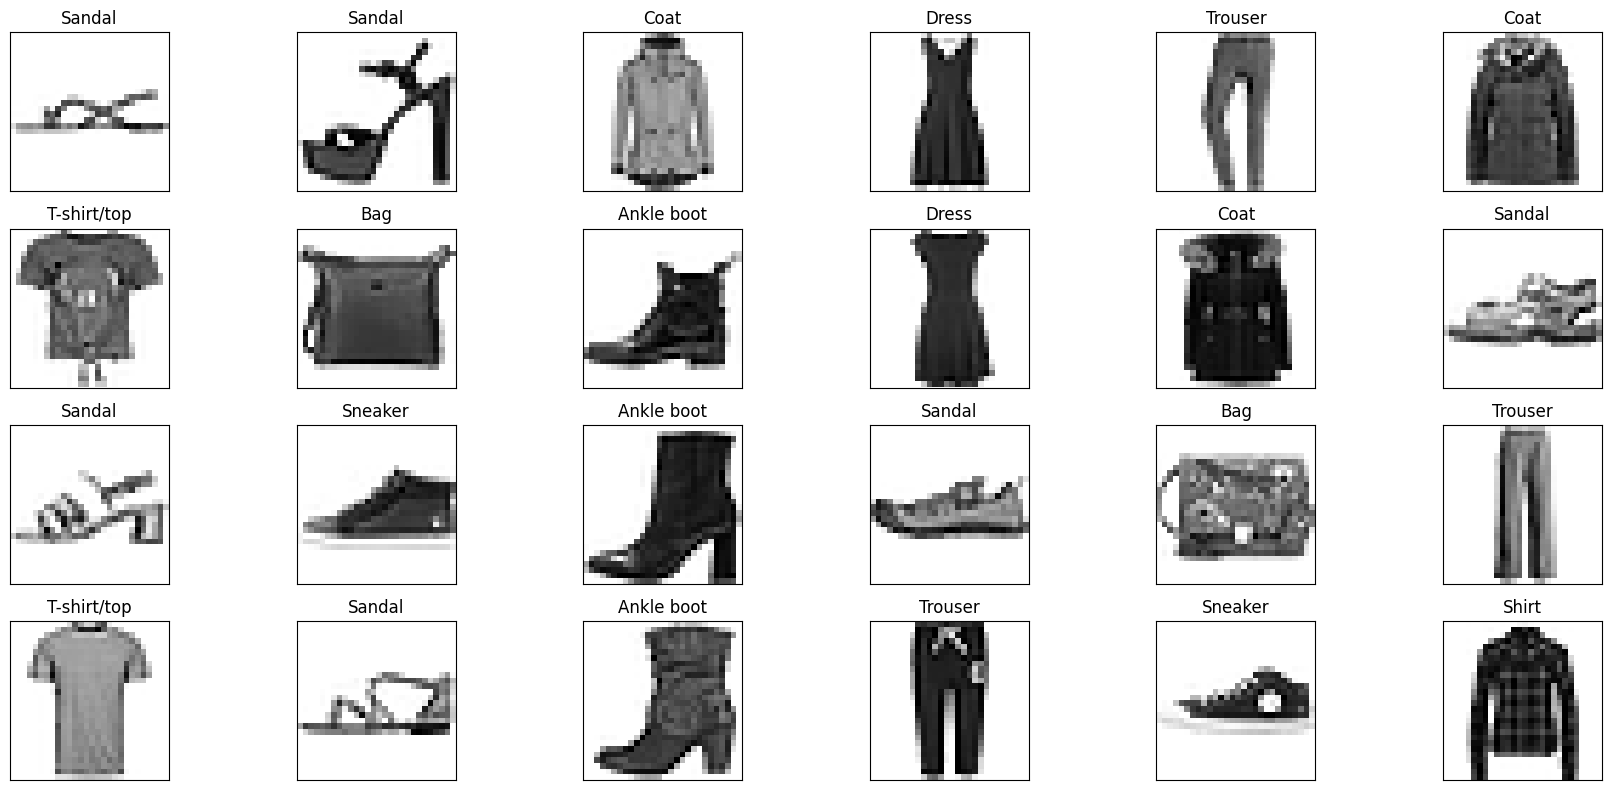

In [ ]:
rows = 4
columns = 6
n = rows*columns

images = x_train[:n]
labels = y_train[:n]

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[labels[i]]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

## **Modelo de clasificación de Imágenes**

Usemos la siguiente arquitecture MLP:
- **Capa de entrada**: 784 neuronas (28*28)
- **Capa oculta 1**: 100 neuronas, activación ReLu
- **Capa oculta 2**: 100 neuronas, activación ReLu
- **Capa oculta 3**: 100 neuronas, activación ReLu
- **Capa de salida**: 10 neuronas, activación Softmax


### **Creando el modelo**

Podemos crear una función para construir un modelo con determinado número de capas ocultas.

In [ ]:
def get_model(hidden_layers, n_classes):
  model = Sequential(name="MyModel")

  model.add(Flatten(input_shape=(28,28,1)))

  for i in hidden_layers:
    model.add(Dense(i,
                    activation=tf.nn.relu))
  model.add(Dense(n_classes, activation=tf.nn.softmax))
  return model

Ahora podemos construir un modelo con la architecture mencionada anteriormente.

In [ ]:
model = get_model(hidden_layers=[100, 100, 100], n_classes=n_classes)

model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 99710 (389.49 KB)
Trainable params: 99710 (389.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Visualización del modelo

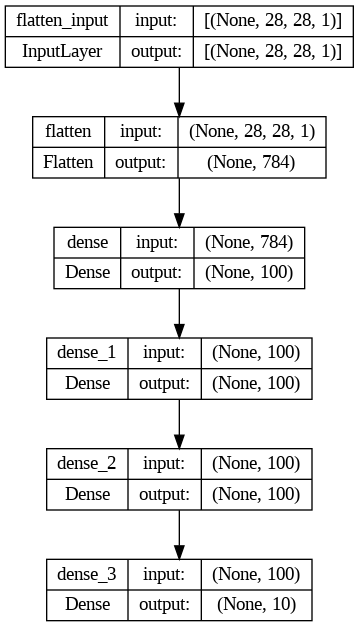

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

### **Configuración del modelo**

Usamos `sparse_categorical_crossentropy` debido a que los labels son números entre `0` y `N-1`, donde `N` es el número de clases disponibles en el conjunto de datos.

In [ ]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy']
              )

# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_autosave = ModelCheckpoint("classification_model.h5",
                                mode="max",
                                save_best_only=True,
                                monitor="val_accuracy",
                                verbose=1)

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
early_stopping = EarlyStopping(patience=40,
                               verbose=1,
                               mode="auto")

callbacks = [mode_autosave, early_stopping]

## **Entrenando el modelo**



Documentación: [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    validation_data=(x_val,y_val),
                    callbacks=callbacks
                    )

Epoch 1/200
1682/1688 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.8202
Epoch 1: val_accuracy improved from -inf to 0.85217, saving model to classification_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1688/1688 [==============================] - 14s 5ms/step - loss: 0.4992 - accuracy: 0.8205 - val_loss: 0.4027 - val_accuracy: 0.8522
Epoch 2/200
1683/1688 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8639
Epoch 2: val_accuracy improved from 0.85217 to 0.86117, saving model to classification_model.h5
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3721 - accuracy: 0.8639 - val_loss: 0.3708 - val_accuracy: 0.8612
Epoch 3/200
1674/1688 [============================>.] - ETA: 0s - loss: 0.3375 - accuracy: 0.8740
Epoch 3: val_accuracy improved from 0.86117 to 0.87200, saving model to classification_model.h5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3375 - accuracy: 0.8740 - val_loss: 0.3479 - val_accuracy: 0.8720
Epoch 4/200
1679/1688 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8843
Epoch 4: val_accuracy improved from 0.87200 to 0.87250, saving model to classification_model.h5
1688/1688 [====

### **Evolución del modelo durante el entrenamiento**

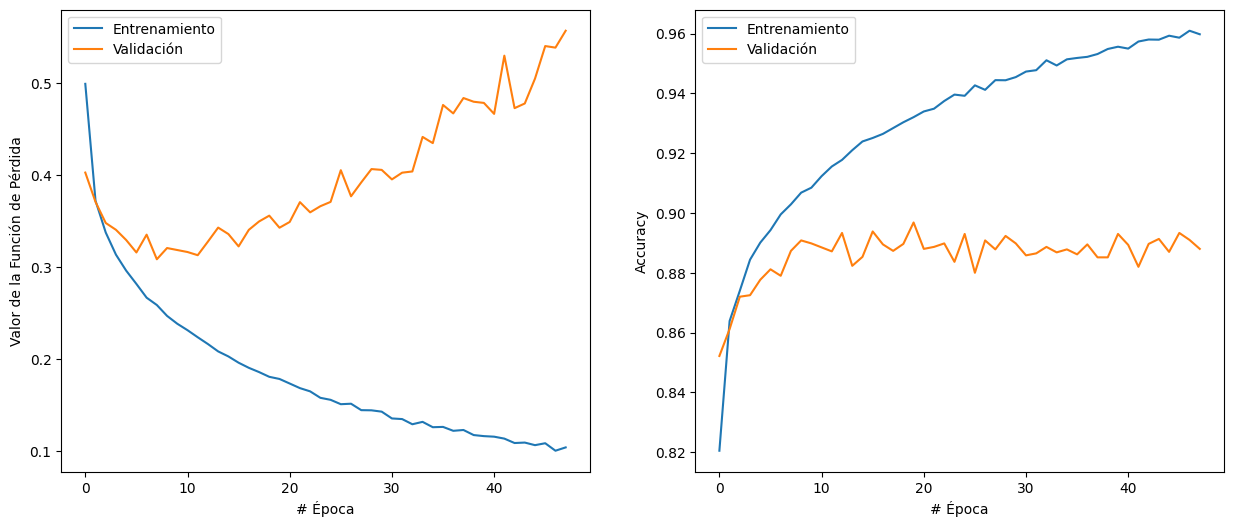

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("# Época")
plt.ylabel("Valor de la Función de Pérdida")
plt.legend(["Entrenamiento", "Validación"])

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("# Época")
plt.ylabel("Accuracy")
plt.legend(["Entrenamiento", "Validación"])

plt.show()

**Pregunta:** ¿Qué podemos observar de estas figuras?

Si ya se entrenó el modelo, podemos comenzar desde este punto para no volver a entrenar el modelo.

In [ ]:
model.load_weights("classification_model.h5")

## **Probando el modelo**

Usaremos la funcion `evaluate` para probar el modelo entrenado con los conjuntos de entrenamiento, validación y pruebas.

In [ ]:
print("Train:")
scores_train = model.evaluate(x_train, y_train)
print("Validation:")
scores_val = model.evaluate(x_val, y_val)
print("Test:")
scores_test = model.evaluate(x_test, y_test)

Train:
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1093 - accuracy: 0.9577
Validation:
188/188 [==============================] - 0s 3ms/step - loss: 0.5569 - accuracy: 0.8880
Test:
313/313 [==============================] - 1s 2ms/step - loss: 0.6525 - accuracy: 0.8830


### **Visualización de resultados**

Funciones para una mejor visualización de los resultados

In [ ]:
def plot_image(prediction, label, image):

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(np.squeeze(image), cmap=plt.cm.binary)
  label_predict = np.argmax(prediction)

  if label_predict == label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(name_labels[label_predict],
                                       100*np.max(prediction),
                                       name_labels[label]),
             color=color)

def plot_bar(prediction, label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  fig = plt.bar(range(10), prediction, color="#777777")
  plt.ylim([0,1])
  label_predict = np.argmax(prediction)

  fig[label_predict].set_color('red')
  fig[label].set_color('green')

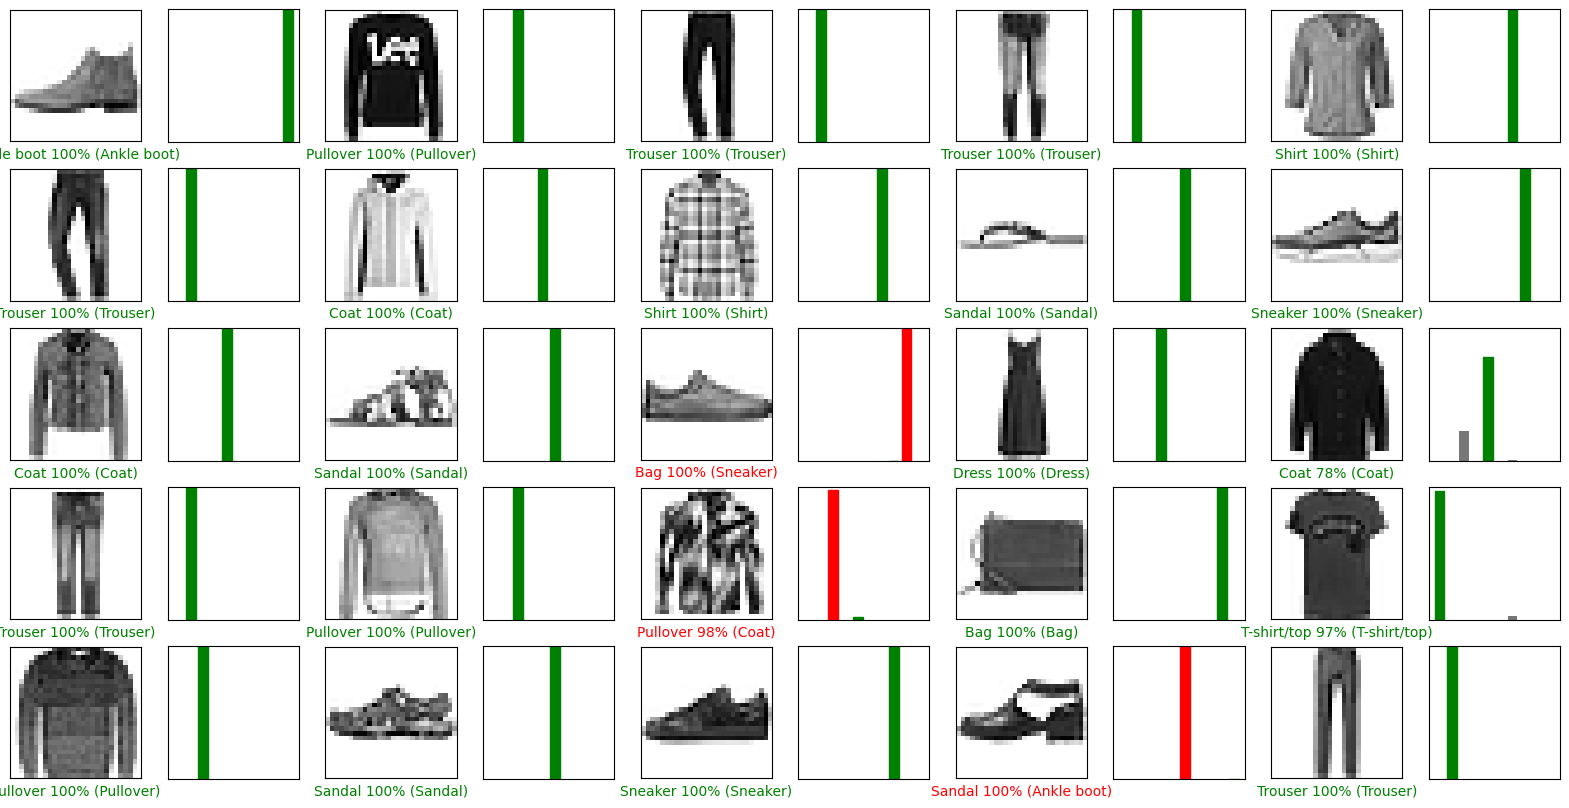

In [ ]:
rows = 5
columns = 5
n_images = rows*columns

plt.figure(figsize=(2*2*columns, 2*rows))

for i in range(n_images):
  image_test = x_test[i]
  image_test = np.expand_dims(np.squeeze(image_test), axis=0)
  label_test = y_test[i]
  prediction = model.predict(image_test, verbose=0)

  plt.subplot(rows, 2*columns, 2*i+1)
  plot_image(prediction[0], label_test, image_test)
  plt.subplot(rows, 2*columns, 2*i+2)
  plot_bar(prediction[0], label_test)

**Preguntas:**

- ¿Cómo podriamos mejorar el modelo?
- ¿Existe algún potencial problema en la metodologia usada (por ejemplo manejo de memoria)?